In [2]:
!pip install einops
# main knowledge neurons class
import torch
import torch.nn.functional as F
import torch.nn as nn
import einops
from tqdm import tqdm
import numpy as np
import collections
from typing import List, Optional, Tuple, Callable

import math
from functools import partial
from transformers import PreTrainedTokenizerBase
import random
from functools import lru_cache
from functools import reduce
import operator

import json
from pathlib import Path 
import os
from glob import glob
import seaborn as sns
import pandas as pd 


from transformers import (
    BertTokenizer,
    BertLMHeadModel,
    GPT2Tokenizer,
    GPT2LMHeadModel,
)

import urllib.request
import random


  Using cached einops-0.6.0-py3-none-any.whl (41 kB)


In [3]:

BERT_MODELS = ["bert-base-uncased"]
GPT2_MODELS = ["gpt2"]
ALL_MODELS = BERT_MODELS + GPT2_MODELS


def initialize_model_and_tokenizer(model_name: str):
    if model_name in BERT_MODELS:
        tokenizer = BertTokenizer.from_pretrained(model_name)
        model= BertLMHeadModel.from_pretrained(model_name)
    elif model_name in GPT2_MODELS:
        tokenizer = GPT2Tokenizer.from_pretrained(model_name)
        model = GPT2LMHeadModel.from_pretrained(model_name)
    else:
        raise ValueError("Model {model_name} not supported")

    model.eval()

    return model, tokenizer


def model_type(model_name: str):
    if model_name in BERT_MODELS:
        return "bert"
    elif model_name in GPT2_MODELS:
        return "gpt2"
    else:
        raise ValueError("Model {model_name} not supported")


In [4]:


PARAREL_RELATION_NAMES = [
    "P39",
    "P264", # Remove the last three patterns
    "P108",
    "P176", # Remove the last two patterns
    "P30",
    "P178", # Remove the last four patterns
    "P138", # Remove pattern 11, 12, 13
    "P47", # Remove last 4 relations / total 9
    "P27", # Remove the first one and the last pattern
    "P364", # Remove last two
    "P495",
    "P449", # Remove 4 out of 11
    "P20",
    "P36", # Remove 6 out of 14
    "P19", # Remove 6 out of 13
    "P740",
    "P279",
    "P159", # Remove 3 out of 10
    "P106", # Remove first 4 out of 11
    "P101", # Remove 3 out of 11
    "P937",
]
# Removed relations: P37, P103, P413, P1376, P1303, P530, P190, P136, P127, P1412, P407, P140,         P131, P463, P17, P1001, P361, P276


def sub_pararel(data_path: str = "datasets/pararel.json", model_type= 'bert'):
    parent_dir = Path(data_path).parent
    os.makedirs(parent_dir, exist_ok=True)
    #if os.path.exists(data_path):
        #with open(data_path, "r") as f:
            #return json.load(f)
    #else:
    PARAREL = collections.defaultdict(dict)
    # download relations from github
    for r in tqdm(PARAREL_RELATION_NAMES, "downloading pararel data"):
        with urllib.request.urlopen(
            f"https://raw.githubusercontent.com/yanaiela/pararel/main/data/pattern_data/graphs_json/{r}.jsonl"
        ) as url:
            graphs = [
                json.loads(d.strip()) for d in url.read().decode().split("\n") if d
            ]
            # Prune the punctuations
            graphs= [
                {'pattern': graph['pattern'].strip('.').strip(',').strip(), 'lemma': graph['lemma'], 
                 'extended_lemma': graph['extended_lemma'], 'tense': graph['tense'] } for graph in graphs 
            ]
            
            
            # Remove the patterns where [Y] is not at the end of the sentence
            # by manually check if [Y] is located at the end of the sentence
            graphs= [
               {'pattern': graph['pattern'], 'lemma': graph['lemma'], 
                 'extended_lemma': graph['extended_lemma'], 'tense': graph['tense'] } for graph in graphs  
                if (graph['pattern'].rindex("[Y]")+ 3== len(graph['pattern']) or graph['pattern'].rindex("[Y]")+ 4== len(graph['pattern'])) #
            ]
            
            # Manually add the punctuations back for the models for convienient in-context learning
            graphs= [
            {'pattern': graph['pattern'] if graph['pattern'][-1] in '?.,!;' else graph['pattern']+ '.', 'lemma': graph['lemma'], 
             'extended_lemma': graph['extended_lemma'], 'tense': graph['tense'] } for graph in graphs 
        ]
            

            PARAREL[r]["graphs"] = graphs
        with urllib.request.urlopen(
            f"https://raw.githubusercontent.com/yanaiela/pararel/main/data/trex_lms_vocab/{r}.jsonl"
        ) as url:
            vocab = [
                json.loads(d.strip()) for d in url.read().decode().split("\n") if d
            ]
            PARAREL[r]["vocab"] = vocab
    with open(data_path, "w") as f:
        json.dump(PARAREL, f)
    return PARAREL


def pararel_expanded(
    data_path: str = "datasets/pararel_expanded.json", obj_label_replacement=None, model_type= 'bert', instances_num= 20
):
    counter= [0 for _ in range(len(PARAREL_RELATION_NAMES))]
    parent_dir = Path(data_path).parent
    os.makedirs(parent_dir, exist_ok=True)
    #if os.path.exists(data_path):
        #with open(data_path, "r") as f:
            #return json.load(f)
    #else:
    PARAREL = sub_pararel(model_type= model_type)
    PARAREL_EXPANDED = collections.defaultdict(dict)
    # expand relations into sentences, grouped by their uui
    for key, value in tqdm(
        PARAREL.items(), "expanding pararel dataset into full sentences"
    ):
        for graph in value["graphs"]:
            for i in range(len(value["vocab"])):
            
                vocab= value["vocab"][i]
                if not PARAREL_EXPANDED.get(vocab["uuid"]):
                    if counter[PARAREL_RELATION_NAMES.index(key)]== instances_num:
                        continue
                    counter[PARAREL_RELATION_NAMES.index(key)]+= 1
                    PARAREL_EXPANDED[vocab["uuid"]] = {
                        "sentences": [],
                        "relation_name": key,
                        "obj_label": " "+ vocab["obj_label"] if not model_type== 'bert' else vocab["obj_label"],
                    }
                sentence = graph["pattern"]
                random_samples= []
                sample_vocab= []
                while len(random_samples)< 4:
                    n = random.randint(0,len(value["vocab"])- 1)
                    if n!= i and value["vocab"][n]["obj_label"]!= vocab["obj_label"] and value["vocab"][n]["obj_label"] not in sample_vocab:
                        sample_vocab.append(value["vocab"][n]["obj_label"])
                        random_samples.append(sentence.replace("[X]", value["vocab"][n]["sub_label"]).replace(
                    "[Y]", value["vocab"][n]["obj_label"])) 
                # Sample random sentences with the same structure to facilitate the in-context learning for gpt models
                
                replace= "[MASK]" if model_type== 'bert' else ''
                full_sentence = sentence.replace("[X]", vocab["sub_label"]).replace(
                    "[Y]", replace
                )
                random_samples.append(full_sentence)
                full_sentences= '\n'.join(random_samples) if model_type== 'bert' else '\n'.join(random_samples).strip('.').strip(',').strip() # Strip the punctuations for the convinience of gpt models
                
                PARAREL_EXPANDED[vocab["uuid"]]["sentences"].append(full_sentences)
    with open(data_path, "w") as f:
        json.dump(PARAREL_EXPANDED, f)
    return PARAREL_EXPANDED


In [5]:
RESULTS_DIR = Path('results')
os.makedirs(RESULTS_DIR, exist_ok=True)
random.seed(2022)

# load dataset
# each item in pararel is the same 'fact' (head/relation/tail) expressed in different ways
PARAREL = pararel_expanded(model_type='gpt', instances_num= 100)

INDICES = list(range(len(PARAREL)))
KEYS = list(PARAREL.keys())
# setup model + tokenizer
model, tokenizer = initialize_model_and_tokenizer('gpt2')
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

expanding pararel dataset into full sentences: 100%|██████████| 21/21 [00:00<00:00, 28.50it/s]


Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/523M [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dro

In [6]:
embedding_matrix = model.transformer.wte.weight
torch.mean(torch.abs(embedding_matrix))

tensor(0.1132, device='cuda:0', grad_fn=<MeanBackward0>)

In [7]:

# initialize results dicts
RESULTS = {}
torch.seed()
# go through each item in the PARAREL dataset, get the refined neurons, save them, and evaluate the results when suppressing the
# refined neurons vs. unrelated neurons.
corrupted= 0
for i, idx in enumerate(tqdm(INDICES, position= 0)): # Change back to INDICES to get the full results
    uuid = KEYS[idx]
    data = PARAREL[uuid]  
    sentences, label, relation= data['sentences'], data["obj_label"], data["relation_name"]
    target_tok= tokenizer.encode(label)[0]
    
    embedding_matrix = model.transformer.wte.weight

    # Get the size of the embedding matrix
    size= embedding_matrix.size()

    # Add normal noise the embedding to do the corrupted run
    with torch.no_grad():
        normal_noise= torch.normal(0.0, 0.03, size= (size[0], size[1])).to(device)
        embedding_matrix+= normal_noise
        
        corrupted= []
        # Avoid padding sentences so not to interrupt the last token prediction
        for sentence in sentences: 
            encoded= tokenizer(sentence, return_tensors= 'pt').to(device)
            outputs= model(**encoded)
            probs= F.softmax(outputs. logits[:, -1, :], dim= -1)[:, target_tok].item()
            corrupted.append(probs)
    
        # Change the matrix back to its original value
        embedding_matrix-= normal_noise
        
        difference= []
        raw= []
        # Avoid padding sentences so not to interrupt the last token prediction
        for idx, sentence in enumerate(sentences): 
            encoded= tokenizer(sentence, return_tensors= 'pt').to(device)
            outputs= model(**encoded)
            probs= F.softmax(outputs. logits[:, -1, :], dim= -1)[:, target_tok].item()
            raw.append(probs)
            difference.append(corrupted[idx]- probs)
            
            
        if relation not in RESULTS:
            RESULTS[relation]= {'difference': difference, 'raw': raw}
        else:
            RESULTS[relation]['difference']+= difference
            RESULTS[relation]['raw']+= raw

100%|██████████| 2053/2053 [17:39<00:00,  1.94it/s]


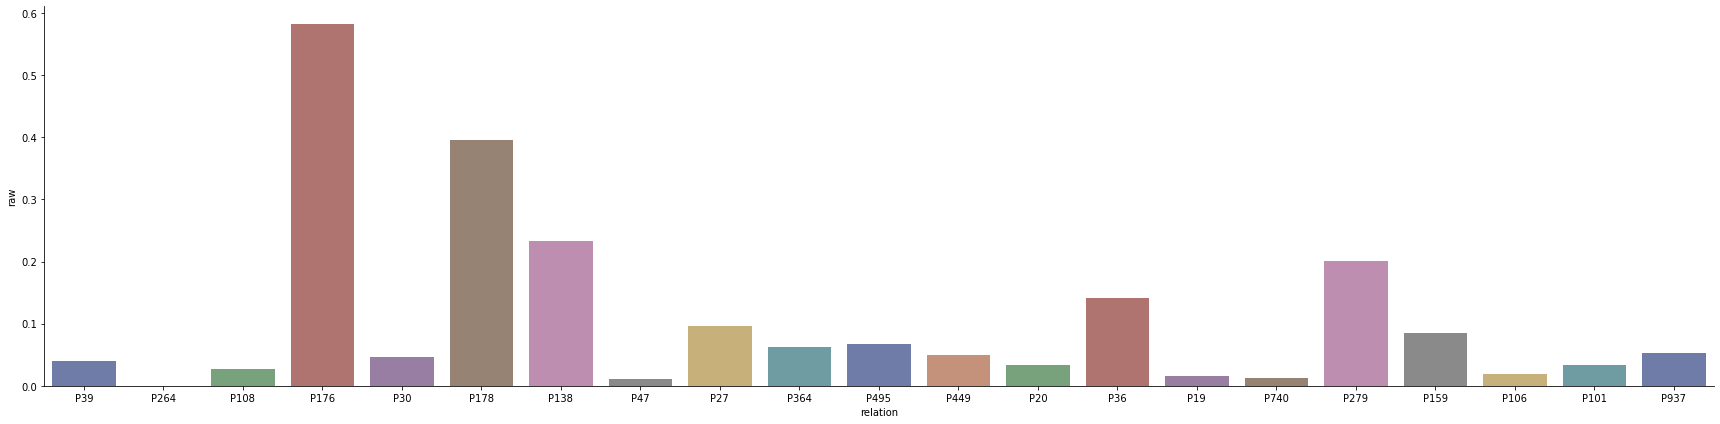

In [8]:
result_gpt_prob= {'relation':[], 'raw': []}

for key in RESULTS:
    dif= RESULTS[key]
    result_gpt_prob['relation'].append(key)
    result_gpt_prob['raw'].append(sum(dif['raw'])/len(dif['raw']))

df_gpt_prob= pd.DataFrame(result_gpt_prob)

sns.catplot(data=df_gpt_prob, x="relation", y='raw',ci="sd", palette="dark", alpha=.6, height=6, aspect=4, kind= 'bar')

In [9]:
df_gpt_prob['raw'].mean()

0.10496058523281478

In [10]:
result_gpt= {'relation':[], 'difference': []}

for key in RESULTS:
    dif= RESULTS[key]
    result_gpt['relation'].append(key)
    result_gpt['difference'].append(sum(dif['difference'])/len(dif['difference']))

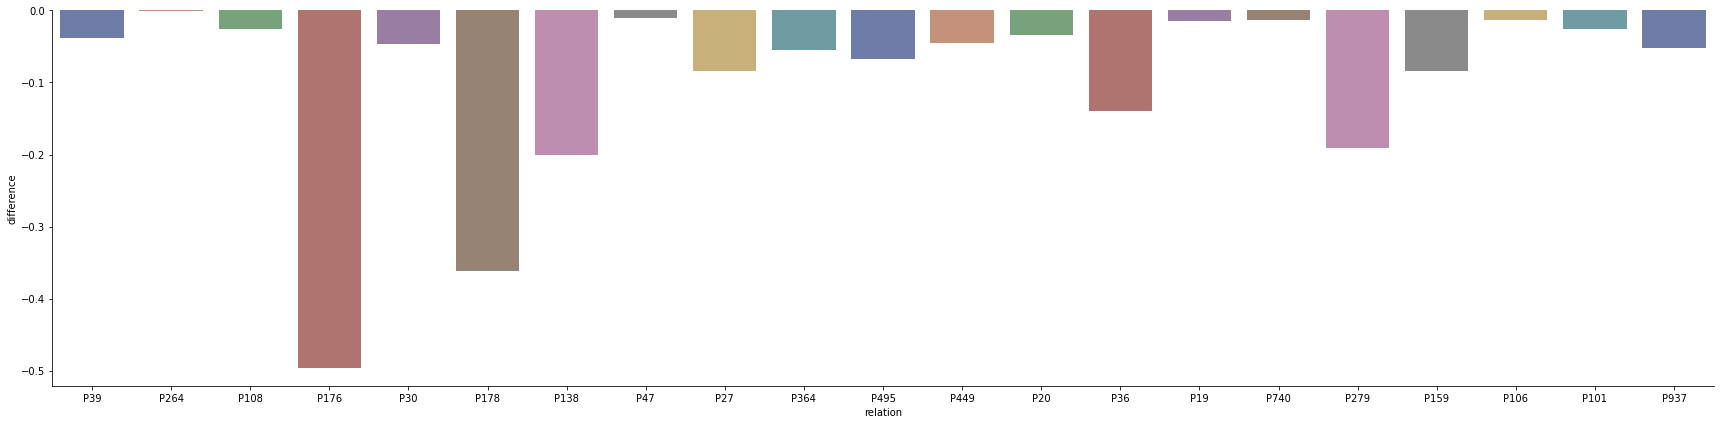

In [11]:
df_gpt= pd.DataFrame(result_gpt)

sns.catplot(data=df_gpt, x="relation", y='difference',ci="sd", palette="dark", alpha=.6, height=6, aspect=4, kind= 'bar')

In [12]:
df_gpt['difference'].mean()

-0.09513395985344937

In [13]:
# load dataset
# each item in pararel is the same 'fact' (head/relation/tail) expressed in different ways
PARAREL_BERT = pararel_expanded(model_type='bert', instances_num= 100)
# setup model + tokenizer
model_bert, tokenizer_bert = initialize_model_and_tokenizer('bert-base-uncased')
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_bert.to(device)
INDICES = list(range(len(PARAREL_BERT)))
KEYS = list(PARAREL_BERT.keys())

expanding pararel dataset into full sentences: 100%|██████████| 21/21 [00:00<00:00, 46.47it/s]


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

If you want to use `BertLMHeadModel` as a standalone, add `is_decoder=True.`
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertLMHeadModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertLMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertLMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [14]:
torch.mean(torch.abs(model_bert.bert.embeddings.word_embeddings.weight))

tensor(0.0408, device='cuda:0', grad_fn=<MeanBackward0>)

In [15]:
# initialize results dicts
RESULTS_BERT = {}
torch.seed()
# go through each item in the PARAREL dataset
corrupted= []
for i, idx in enumerate(tqdm(INDICES, position= 0)): # Change back to INDICES to get the full results
    uuid = KEYS[idx]
    data = PARAREL_BERT[uuid]
    sentences, label, relation= data['sentences'], data["obj_label"], data["relation_name"]
    target_tok= tokenizer_bert.convert_tokens_to_ids(label.lower()) if tokenizer_bert.convert_tokens_to_ids(label)== 100 else tokenizer_bert.convert_tokens_to_ids(label)
    
    embedding_matrix = model_bert.bert.embeddings.word_embeddings.weight

    # Get the size of the embedding matrix
    size= embedding_matrix.size()

    # Add normal noise the embedding to do the corrupted run
    with torch.no_grad():
        normal_noise= torch.normal(0.0, 0.01, size= (size[0], size[1])).to(device)
        embedding_matrix+= normal_noise
        
        corrupted= []
        # Avoid padding sentences so not to interrupt the last token prediction
        for sentence in sentences: 
            encoded= tokenizer_bert(sentence, return_tensors= 'pt').to(device)
            outputs= model_bert(**encoded)
            probs= F.softmax(outputs. logits[:, -3, :], dim= -1)[:, target_tok].item()
            corrupted.append(probs)
    
        # Change the matrix back to its original value
        embedding_matrix-= normal_noise
        
        difference= []
        raw= []
        # Avoid padding sentences so not to interrupt the last token prediction
        for idx, sentence in enumerate(sentences): 
            encoded= tokenizer_bert(sentence, return_tensors= 'pt').to(device)
            outputs= model_bert(**encoded)
            probs= F.softmax(outputs. logits[:, -3, :], dim= -1)[:, target_tok].item()
            raw.append(probs)
            difference.append(corrupted[idx]- probs)
            
            
        if relation not in RESULTS_BERT:
            RESULTS_BERT[relation]= {'difference': difference, 'raw': raw}
        else:
            RESULTS_BERT[relation]['difference']+= difference
            RESULTS_BERT[relation]['raw']+= raw

100%|██████████| 2053/2053 [12:36<00:00,  2.71it/s]


In [16]:
result_bert= {'relation':[], 'difference': []}

for key in RESULTS_BERT:
    dif= RESULTS_BERT[key]
    result_bert['relation'].append(key)
    result_bert['difference'].append(sum(dif['difference'])/len(dif['difference']))

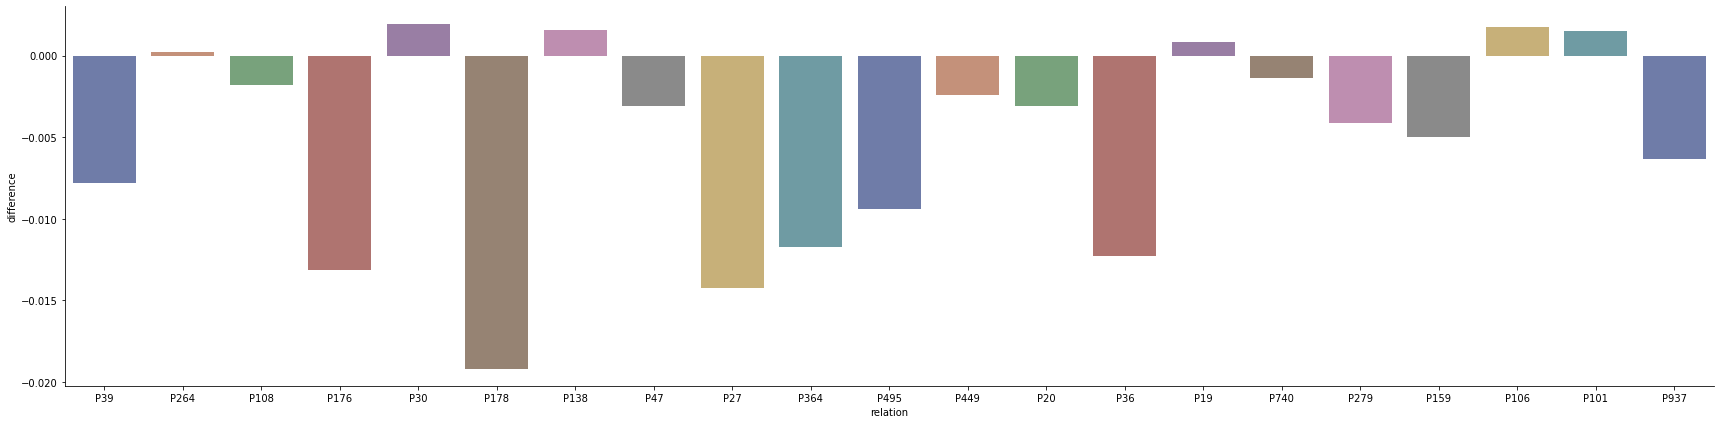

In [17]:
df_bert= pd.DataFrame(result_bert)

sns.catplot(data=df_bert, x="relation", y='difference',ci="sd", palette="dark", alpha=.6, height=6, aspect=4, kind= 'bar')

In [18]:
df_bert['difference'].mean()

-0.005106656819614021

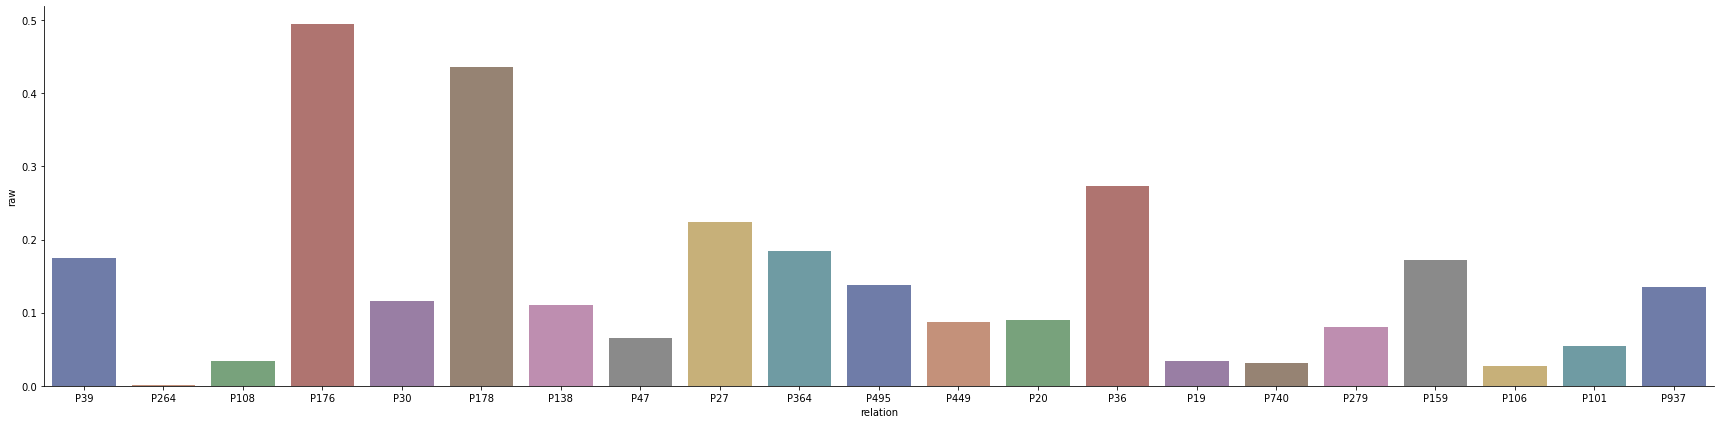

In [19]:
result_bert_prob= {'relation':[], 'raw': []}

for key in RESULTS_BERT:
    dif= RESULTS_BERT[key]
    result_bert_prob['relation'].append(key)
    result_bert_prob['raw'].append(sum(dif['raw'])/len(dif['raw']))

df_bert_prob= pd.DataFrame(result_bert_prob)

sns.catplot(data=df_bert_prob, x="relation", y='raw',ci="sd", palette="dark", alpha=.6, height=6, aspect=4, kind= 'bar')

In [20]:
df_bert_prob['raw'].mean()

0.14111097209371876